<a href="https://colab.research.google.com/github/laruvinga/machinelearning/blob/master/RESNET_50_Detecting_Slums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from glob import glob
import os
import shutil
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Define constants

num_classes = 2
tmp_dir = "/tmp"
resnet_weights_path = tmp_dir + "/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
resnet_weights_url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
dataset_dir = "/content/drive/My Drive/SatelliteML/Test_100"
dataset_train = dataset_dir + "/unbalanced_train.tar"
dataset_validation = dataset_dir + "/unbalanced_validation.tar"
dataset_test = dataset_dir + "/unbalanced_test.tar"
train_dir = tmp_dir + "/dataset_train";
valid_dir = tmp_dir + "/dataset_valid";
test_dir = tmp_dir + "/dataset_test";
trained_weights_path = dataset_dir + "/resnet50_weights_trained.h5"
# dataset_url = "https://github.com/laruvinga/machinelearning/raw/master/byo_ngozi.tar.bz2"

In [0]:
# Get Files
tf.keras.utils.get_file(resnet_weights_path, resnet_weights_url)

'/tmp/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
# Extract dataset
shutil.unpack_archive(dataset_train, train_dir, "tar")
shutil.unpack_archive(dataset_validation, valid_dir, "tar")
shutil.unpack_archive(dataset_test, test_dir, "tar")

In [0]:
# Create model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
model.add(Dense(num_classes, activation='softmax'))
model.layers[0].trainable = False
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

W0903 02:15:45.339144 139982552590208 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
image_size = 150
nb_train_samples = 5216 # number of files in training set
batch_size = 16

EPOCHS = 10
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
       directory = train_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = valid_dir,
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = test_dir,
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS,
       validation_data=validation_generator) # specify where model gets validation data

# Evaluate the model
scores = model.evaluate_generator(train_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Found 45368 images belonging to 2 classes.
Found 5661 images belonging to 2 classes.
Found 5631 images belonging to 2 classes.
Epoch 1/10
326/326 [==============================] - 69s 213ms/step - loss: 0.0662 - acc: 0.9893 - val_loss: 0.0707 - val_acc: 0.9910
Epoch 2/10
326/326 [==============================] - 62s 190ms/step - loss: 0.0412 - acc: 0.9919 - val_loss: 0.0591 - val_acc: 0.9912
Epoch 3/10
326/326 [==============================] - 63s 192ms/step - loss: 0.0361 - acc: 0.9921 - val_loss: 0.0769 - val_acc: 0.9896
Epoch 4/10
326/326 [==============================] - 62s 191ms/step - loss: 0.0443 - acc: 0.9893 - val_loss: 0.0666 - val_acc: 0.9899
Epoch 5/10
326/326 [==============================] - 62s 190ms/step - loss: 0.0364 - acc: 0.9919 - val_loss: 0.0754 - val_acc: 0.9883
Epoch 6/10
326/326 [==============================] - 62s 190ms/step - loss: 0.0359 - acc: 0.9891 - val_loss: 0.0759 - val_acc: 0.9885
Epoch 7/10
326/326 [==============================] - 62s 190ms

In [0]:
model.save(trained_weights_path, overwrite=True)

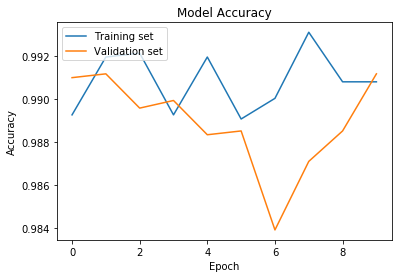

In [0]:
# Accuracy 
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

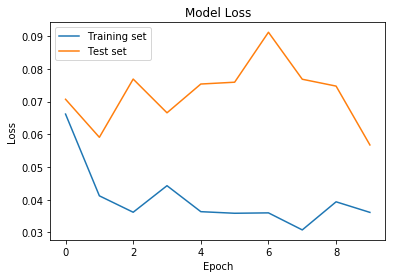

In [0]:
# Loss 
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()